# AutoTabPFN TS

In [1]:
dataset_metadata = {
    "monash_tourism_monthly": {"prediction_length": 24},
    "m4_hourly": {"prediction_length": 48},
}

dataset_choice = "monash_tourism_monthly"
num_time_series_subset = 2

In [2]:
from datasets import load_dataset
from tabpfn_time_series import TimeSeriesDataFrame
from tabpfn_time_series.data_preparation import generate_test_X, to_gluonts_univariate

prediction_length = dataset_metadata[dataset_choice]["prediction_length"]
dataset = load_dataset("autogluon/chronos_datasets", dataset_choice)

tsdf = TimeSeriesDataFrame(to_gluonts_univariate(dataset["train"]))
tsdf = tsdf[
    tsdf.index.get_level_values("item_id").isin(tsdf.item_ids[:num_time_series_subset])
]
train_tsdf, test_tsdf_ground_truth = tsdf.train_test_split(
    prediction_length=prediction_length
)
test_tsdf = generate_test_X(train_tsdf, prediction_length)

/home/klemens_priorlabs_ai/tabpfn-extensions/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


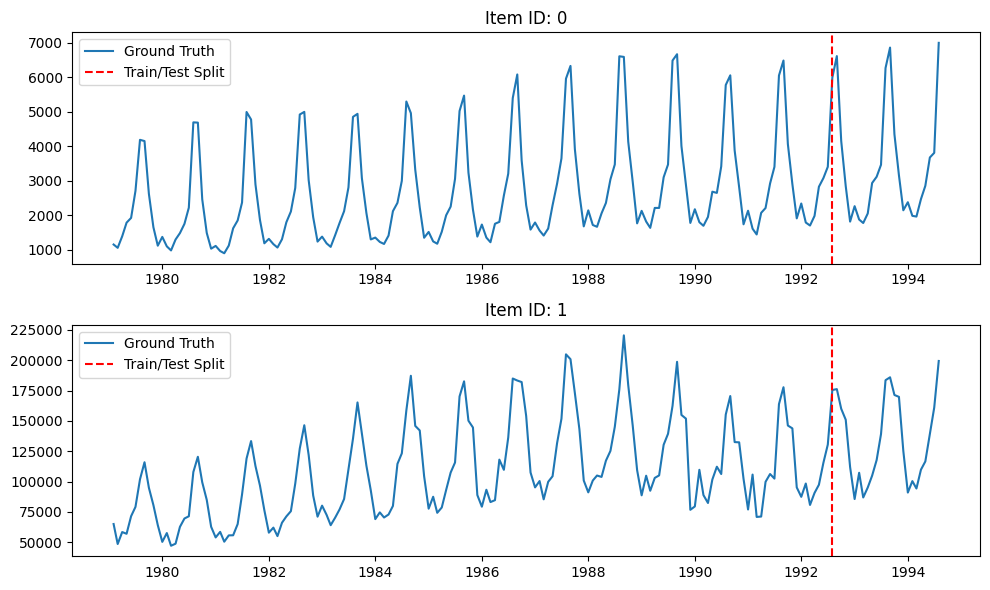

In [3]:
from tabpfn_time_series.plot import plot_actual_ts

plot_actual_ts(train_tsdf, test_tsdf_ground_truth)

In [4]:
from tabpfn_time_series import FeatureTransformer
from tabpfn_time_series.features import (
    AutoSeasonalFeature,
    CalendarFeature,
    RunningIndexFeature,
)

selected_features = [
    RunningIndexFeature(),
    CalendarFeature(),
    AutoSeasonalFeature(),
]

feature_transformer = FeatureTransformer(selected_features)

train_tsdf, test_tsdf = feature_transformer.transform(train_tsdf, test_tsdf)

In [5]:
train_tsdf.head()

target  running_index  year  second_of_minute_sin  \
item_id timestamp                                                          
0       1979-01-31  1149.8700              0  1979                   0.0   
        1979-02-28  1053.8002              1  1979                   0.0   
        1979-03-31  1388.8798              2  1979                   0.0   
        1979-04-30  1783.3702              3  1979                   0.0   
        1979-05-31  1921.0252              4  1979                   0.0   

                    second_of_minute_cos  minute_of_hour_sin  \
item_id timestamp                                              
0       1979-01-31                   1.0                 0.0   
        1979-02-28                   1.0                 0.0   
        1979-03-31                   1.0                 0.0   
        1979-04-30                   1.0                 0.0   
        1979-05-31                   1.0                 0.0   

                    minute_of_hour_cos  hour_of_day_sin  hour_of_day_cos  \
item_id timestamp                                                          
0       1979-01-31                 1.0              0.0              1.0   
        1979-02-28                 1.0              0.0              1.0   
        1979-03-31                 1.0              0.0              1.0   
        1979-04-30                 1.0              0.0              1.0   
        1979-05-31                 1.0              0.0              1.0   

                    day_of_week_sin  ...    sin_#0        cos_#0  \
item_id timestamp                    ...                           
0       1979-01-31     8.660254e-01  ...  0.000000  1.000000e+00   
        1979-02-28     8.660254e-01  ...  0.500000  8.660254e-01   
        1979-03-31    -8.660254e-01  ...  0.866025  5.000000e-01   
        1979-04-30     0.000000e+00  ...  1.000000  6.123234e-17   
        1979-05-31     1.224647e-16  ...  0.866025 -5.000000e-01   

                          sin_#1  cos_#1        sin_#2        cos_#2  \
item_id timestamp                                                      
0       1979-01-31  0.000000e+00     1.0  0.000000e+00  1.000000e+00   
        1979-02-28  8.660254e-01     0.5  1.000000e+00  6.123234e-17   
        1979-03-31  8.660254e-01    -0.5  1.224647e-16 -1.000000e+00   
        1979-04-30  1.224647e-16    -1.0 -1.000000e+00 -1.836970e-16   
        1979-05-31 -8.660254e-01    -0.5 -2.449294e-16  1.000000e+00   

                          sin_#3  cos_#3        sin_#4  cos_#4  
item_id timestamp                                               
0       1979-01-31  0.000000e+00     1.0  0.000000e+00     1.0  
        1979-02-28  1.224647e-16    -1.0  8.660254e-01    -0.5  
        1979-03-31 -2.449294e-16     1.0 -8.660254e-01    -0.5  
        1979-04-30  3.673940e-16    -1.0 -2.449294e-16     1.0  
        1979-05-31 -4.898587e-16     1.0  8.660254e-01    -0.5  

[5 rows x 29 columns]

In [6]:

from tabpfn_extensions import AutoTabPFN_TS_Regressor
x_train = train_tsdf.drop(columns=['target']).copy()
y_train = train_tsdf['target'].copy()

model = AutoTabPFN_TS_Regressor()
model.fit(X=x_train, y=y_train)


/home/klemens_priorlabs_ai/tabpfn-extensions/.venv/lib/python3.10/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


ValueError: Custom model type <class 'autogluon.tabular.models.tabpfnv2.tabpfnv2_model.TabPFNV2Model'> must inherit from `AbstractTimeSeriesModel`.

In [ ]:
from tabpfn_time_series import TabPFNMode, TabPFNTimeSeriesPredictor

predictor = TabPFNTimeSeriesPredictor(
    tabpfn_mode=TabPFNMode.LOCAL,  # adapt this to TabPFNMode.CLIENT if using API
)

pred = predictor.predict(train_tsdf, test_tsdf)

GPU 0:: 100%|██████████| 1/1 [00:05<00:00,  5.85s/it]


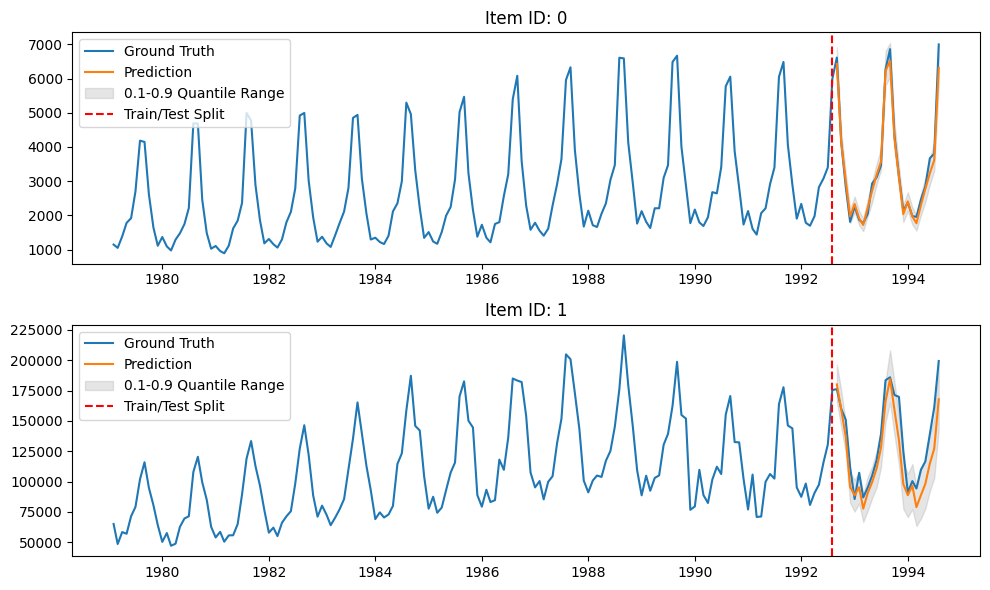

In [ ]:
from tabpfn_time_series.plot import plot_pred_and_actual_ts

plot_pred_and_actual_ts(
    train=train_tsdf,
    test=test_tsdf_ground_truth,
    pred=pred,
)

## AutoTabPFN Time Series

In [ ]:
from tabpfn_extensions import AutoTabPFN_TS_Regressor


/home/klemens_priorlabs_ai/tabpfn-extensions/.venv/lib/python3.10/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [ ]:

from tabpfn_extensions import AutoTabPFN_TS_Regressor
x_train = train_tsdf.drop(columns=['target']).copy()
y_train = train_tsdf['target'].copy()

model = AutoTabPFN_TS_Regressor()
model.fit(X=x_train, y=y_train)


TypeError: TimeSeriesPredictor.fit() got an unexpected keyword argument 'num_bag_folds'